# Regression modeling

**Regression Modelling in Python with Scikit-learn**

In this section, we will explore regression modelling using Python and the popular machine learning library, Scikit-learn. Regression is a supervised learning task that aims to model the relationship between input variables (features) and a continuous output variable (target).

Scikit-learn provides a wide range of regression algorithms, including linear regression, random forests, catboost, and XGBoost. We will cover the basics of each algorithm and demonstrate how to implement them using Scikit-learn.

**Linear Regression**

Linear regression is a simple yet powerful regression algorithm that models the relationship between features and the target as a linear function. We will discuss the assumptions of linear regression, how to train a model, and how to evaluate its performance using the root mean squared error (RMSE).

**Random Forest**

Random forests are an ensemble learning method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. Each tree in the forest is trained on a random subset of the data, and the final prediction is made by averaging the predictions of all the trees. Random forests are particularly useful for handling complex relationships and interactions between features, and they are also robust to outliers and noise in the data. We will demonstrate how to use random forests to model complex relationships and how to tune hyperparameters such as the number of trees and the maximum depth of the trees.

**CatBoost**

CatBoost is a gradient boosting algorithm that is known for its speed and accuracy. It uses a novel algorithm called "ordinal encoding" to handle categorical variables, which allows it to handle large numbers of categories efficiently. However, CatBoost can also be used for regression tasks that do not involve categorical data. We will demonstrate how to use CatBoost to model complex relationships and how to tune hyperparameters such as the learning rate and the number of iterations.

**XGBoost**

XGBoost is a gradient boosting algorithm that is known for its speed and accuracy in regression tasks. It uses a novel algorithm called "tree boosting" to combine multiple decision trees, which allows it to handle complex relationships and interactions between features. We will demonstrate how to use XGBoost to model complex relationships and how to tune hyperparameters such as the learning rate, the number of trees, and the maximum depth of the trees.

**Model Selection and Hyperparameter Tuning**

In addition to the regression algorithms themselves, Scikit-learn provides tools for model selection and hyperparameter tuning. We will discuss the importance of model selection and hyperparameter tuning, and demonstrate how to use Scikit-learn's GridSearchCV and RandomizedSearchCV classes to find the best set of hyperparameters for a given regression algorithm.


In [7]:
#pip install catboost

In [8]:
#pip install shap

In [86]:
# Import libraries

import catboost as cb
import numpy as np
from numpy import absolute
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



# Remove this once we combine notebooks!

In [115]:
# Load .csv data as dataframes and make patient_id the index

df_train = pd.read_csv('data/df_train_hot_index.csv', index_col='patient_id')
df_test = pd.read_csv('data/df_test_hot_index.csv', index_col='patient_id')

# Look at the first few rows of data
df_train.head()

,payer_type,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,family_dual_income,income_household_10_to_15,education_bachelors,labor_force_participation,poverty,Average of May-15,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,
268700,0,724,39,45,41,3,43.99,8.52,9.21,53.60,19.27,68.49,191
484983,3,629,55,29,7,3,41.41,6.58,12.46,52.51,16.94,66.81,33
277055,0,925,59,7,18,3,52.89,3.16,13.92,59.47,12.72,68.06,157
320055,1,900,59,44,39,3,55.53,6.81,23.89,64.39,20.76,62.56,146
190386,0,934,71,6,34,32,51.88,2.56,19.14,55.20,10.34,58.19,286


In [42]:
df_train.shape

(13168, 13)

## Separate training and test data from df_train

In [116]:
# Create X and y dataframes

target_column = 'metastatic_diagnosis_period'

X = df_train.drop(target_column, axis=1)
y = df_train[target_column]

X.shape

(13168, 12)

In [72]:
y.shape

(13168,)

## Create train/test splits

**train_test_split** is a common method for splitting data into training and testing sets. However, it does not handle class imbalance well and may result in uneven class distributions in the training and testing sets.

**StratifiedShuffleSplit** is a cross-validation method that can be used when the target variable has a significant class imbalance. It randomly divides the data into training and testing sets, ensuring that the proportions of classes in both sets remain the same as those in the original data. This is useful when dealing with data where one class represents a minority or outlier.

Below we will demonstrate how to use each approach. **You will only use one or the other, not both.**

Let's try using train_test_split first, then come back and try stratified_train_test_split

### train_test_split

Use this or StratifiedShuffleSplit, not both

In [117]:
# Create train/test splits using train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [74]:
X_train.shape

(10534, 12)

### StratifiedShuffleSplit

Use this or train_test_split, not both

In [57]:
def split_X_y(df, column_name, row_idx=None):
    columns = df.columns.values.tolist()
    columns.remove(column_name)
    if row_idx is None:
        return df[columns], df[column_name]
    else:
        return df[columns].iloc[row_idx], df[column_name].iloc[row_idx]

In [58]:
def stratified_train_test_split(df):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
    train_idx, test_idx = next(sss.split(*split_X_y(df, target_column)))
    X_train, y_train = split_X_y(df, target_column, train_idx)
    X_test, y_test = split_X_y(df, target_column, test_idx)

    return X_train, y_train, X_test, y_test

In [59]:
X_train, y_train, X_test, y_test = stratified_train_test_split(df_train)

## Function to predict on df_test data and create csv for Kaggle submission

In [118]:
def predict_test_data(model, df_test):
    y_pred = model.predict(df_test)
    df_test['metastatic_diagnosis_period'] = y_pred.tolist()
    answers = df_test['metastatic_diagnosis_period']
    answers.to_csv("output/answers.csv")
    return

## Linear Regression

In [91]:
# Create the linear regression model
model = LinearRegression()

In [92]:
model.fit(X_train,y_train)

LinearRegression()

In [93]:
# Evaluate the model using RMSE
rmse = np.sqrt(np.mean((y - model.predict(X)) ** 2))
print("RMSE:", rmse)

RMSE: 89.18333456479505


### Predict on test data and generate csv for Kaggle submission

In [94]:
predict_test_data(model, df_test)

## Random Forest

In [95]:
# Create the linear random forest model
model = RandomForestRegressor(n_estimators=10, random_state=42)

In [96]:
param_grid = {
   'n_estimators': [100, 200, 500],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [4,5,6,7,8]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_ 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
75 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}

In [103]:
model = RandomForestRegressor(n_estimators=500, max_features = 'sqrt', max_depth = 8, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: ', rmse)

RMSE:  80.53901242268746


### Predict on test data and generate csv for Kaggle submission

In [104]:
predict_test_data(model, df_test)

## XGBoost

XGBoost is a gradient boosting algorithm that is known for its speed and accuracy in regression tasks.

In [119]:
# Define the model
model = XGBRegressor()

In [120]:
# Define the model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [121]:
# Evaluate the model using cross validation
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

In [122]:
print("Cross-validation Mean Squared Error: ", scores.mean())

Cross-validation Mean Squared Error:  -7504.156554916636


In [123]:
# Force scores to be positive
scores = absolute(scores.mean())

In [124]:
rmse = np.sqrt(scores)

In [125]:
print('Mean RMSE: %.3f' % (rmse.mean()))

Mean RMSE: 86.627


In [126]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Predict on test data and generate csv for Kaggle submission

In [127]:
predict_test_data(model, df_test)

## CatBoost

CatBoost is a gradient boosting algorithm that is known for its speed and accuracy.

In [76]:
'''
Here's an overview of what the code does:

cb is a shorthand for the CatBoost module.
Pool is a class in CatBoost that represents a dataset. It takes two arguments: the feature matrix (X_train and X_test) and the target vector 
(y_train and y_test). The two Pool objects are created using the feature matrices and target vectors. These objects will be used to train 
and evaluate the model.

So, in summary, the code creates two Pool objects, which represent the training and testing datasets, respectively.
'''

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [77]:
# Create the CatBoost regression model using RMSE as the loss function

model = cb.CatBoostRegressor(loss_function='RMSE')

In [78]:
'''
This Python code snippet demonstrates how to use the GridSearchCV class from the scikit-learn library to perform hyperparameter tuning 
for a regression model. The GridSearchCV class takes a grid of hyperparameters and trains the model with different combinations of 
these hyperparameters.

In this example, the grid contains four hyperparameters: iterations, learning_rate, depth, and l2_leaf_reg. The iterations hyperparameter 
controls the number of iterations the model will run for, the learning_rate hyperparameter controls the learning rate of the model, the 
depth hyperparameter controls the maximum depth of the trees in the model, and the l2_leaf_reg hyperparameter controls the regularization 
strength of the model.

The GridSearchCV class then trains the model with different combinations of these hyperparameters and evaluates the performance of the 
model using the mean squared error metric. The best combination of hyperparameters is then selected based on the performance of the model.
'''

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset, verbose=1)

# Compare GridSearchCV results to CatBoost grid_search
#grid_search = GridSearchCV(model, grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(X_train, y_train)


0:	learn: 142.6925470	test: 142.3912930	best: 142.3912930 (0)	total: 64.6ms	remaining: 6.39s
1:	learn: 139.8817794	test: 139.6917875	best: 139.6917875 (1)	total: 71ms	remaining: 3.48s
2:	learn: 137.2338242	test: 137.1281215	best: 137.1281215 (2)	total: 76.3ms	remaining: 2.47s
3:	learn: 134.6515708	test: 134.6416893	best: 134.6416893 (3)	total: 78.7ms	remaining: 1.89s
4:	learn: 132.2404269	test: 132.3064037	best: 132.3064037 (4)	total: 79.7ms	remaining: 1.51s
5:	learn: 129.9271730	test: 130.0672906	best: 130.0672906 (5)	total: 80.7ms	remaining: 1.26s
6:	learn: 127.6843183	test: 127.9014176	best: 127.9014176 (6)	total: 81.7ms	remaining: 1.08s
7:	learn: 125.5385012	test: 125.8285431	best: 125.8285431 (7)	total: 82.6ms	remaining: 950ms
8:	learn: 123.4478508	test: 123.8186590	best: 123.8186590 (8)	total: 83.6ms	remaining: 845ms
9:	learn: 121.4437729	test: 121.8963270	best: 121.8963270 (9)	total: 93.6ms	remaining: 842ms
10:	learn: 119.5912338	test: 120.1026372	best: 120.1026372 (10)	total: 9

{'params': {'depth': 4,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5,
  'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

Now that we have the best model from the grid search, we will apply it to our test dataset.

The RMSE metric measures the average squared difference between the predicted values and the actual values. A lower RMSE indicates a better fit.

The R-squared metric measures the proportion of the variance in the target variable that is explained by the model. An R-squared value of 1 indicates that the model explains all of the variance in the target variable, while a value of 0 indicates that the model does not explain any of the variance.

In [79]:
'''
The predict method is used to make predictions on the test dataset, and the results are stored in the pred variable. It is important 
to note that the predict method should only be used on a test dataset that has not been used for training the model. Using the predict 
method on a training dataset can lead to overfitting and poor generalizability of the model.

The metrics RMSE and R2 are then calculated.
'''

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 80.15
R2: 0.46


### Predict on the real test data and create the csv for Kaggle submission

In [85]:
predict_test_data(model, df_test)

### Submit results to Kaggle!

### CatBoost feature importance

In [82]:
feature_names = X.columns

In [83]:
print(feature_names)

Index(['payer_type', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'family_dual_income',
       'income_household_10_to_15', 'education_bachelors',
       'labor_force_participation', 'poverty', 'Average of May-15'],
      dtype='object')


Text(0.5, 0, 'CatBoost Feature Importance')

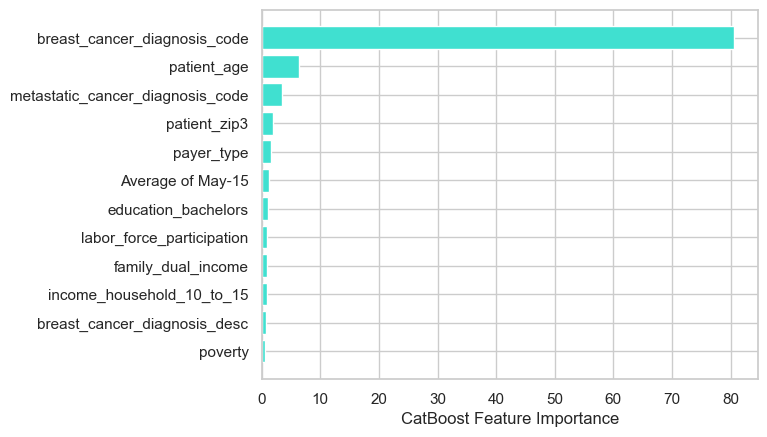

In [84]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(feature_names[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")